# Measuring all 5 protocols and 4 player sizes (720p+) (quality auto) on the test VM -- 2 videos

In [262]:
import pandas as pd
import sqlite3
import datetime
import numpy as np
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import PercentFormatter
import math
import Cdf
import Pmf
from urllib.parse import urlparse, parse_qs
mpl.rcParams['figure.dpi'] = 200
okabe_ito = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
sns.set_context('paper')
sns.set_palette(sns.color_palette(okabe_ito))
#https://stackoverflow.com/a/45846841
def human_format(num):
    num = float('{:.3g}'.format(num))
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    return '{}{}'.format('{:f}'.format(num).rstrip('0').rstrip('.'), ['', 'K', 'M', 'B', 'T'][magnitude])
def make_cdf(series):
    return series.value_counts(normalize=True).sort_index().cumsum()
def make_pdf(series):
    return series.value_counts(normalize=True).sort_index()
from mpl_toolkits.axes_grid1 import make_axes_locatable
from datetime import datetime

In [2]:
conn = sqlite3.connect('web-performance-youtube-two-videos.db')

#### remove measurements where googlevideo subdomain changed

In [3]:
googlevideo_subdomains = pd.read_sql_query("SELECT msm_id, name FROM page_resources", conn)
googlevideo_subdomains['googlevideo'] = googlevideo_subdomains.name.str.split('/').str[2]

In [5]:
googlevideo_subdomains.groupby('msm_id', as_index=False).agg({'googlevideo':pd.Series.nunique}).sort_values('googlevideo').googlevideo.value_counts()

1    10296
2       23
3        1
Name: googlevideo, dtype: int64

In [6]:
msm_ids_to_remove = googlevideo_subdomains.groupby('msm_id', as_index=False).filter(lambda x: pd.Series.nunique(x['googlevideo']) > 1).msm_id.unique().tolist()

#### remove measurement runs where resolution failed in the lookups table -- sadly the timestamps of dnsproxy are not reliable, so we cannot know from just looking at the lookups at which point of playback it failed -- in this run no googlevideo.com resolution failed, however removing them anyway in case it skews results -- also all errors happened over DoUDP

In [7]:
failed_lookups = pd.read_sql_query('SELECT measurement_id as msm_id FROM lookups WHERE status <> "NOERROR"', conn).msm_id.tolist()

In [8]:
msm_ids_to_remove.extend(failed_lookups)

In [9]:
#conn = sqlite3.connect('web-performance-youtube-two-videos.db')
measurements = pd.read_sql_query("SELECT * FROM measurements", conn)
measurements
#conn.close()

,msm_id,py_time,js_time,resource_time_origin,protocol,server,domain,vantagePoint,timestamp,suggested_quality,player_width,player_height,start_time,play_time,video_ids,cacheWarming,error
0,315fc1b3-1c8b-1a99-619f-b6710c7ef174,-1,-1.000000e+00,-1.000000e+00,tls,94.140.14.140,aqz-KE-bpKQ,,2022-02-28 15:37:15.423442,auto,1280,720,0,30,"aqz-KE-bpKQ, lqiN98z6Dak",1,
1,77ca19fd-cf26-e754-72d5-ad927757591e,1646062671917013199,1.646063e+12,1.646063e+12,tls,94.140.14.140,aqz-KE-bpKQ,,2022-02-28 15:37:18.520742,auto,1280,720,0,30,"aqz-KE-bpKQ, lqiN98z6Dak",0,
2,86a4f8aa-3794-71ea-6511-502b73830cb9,-1,-1.000000e+00,-1.000000e+00,tls,94.140.14.140,lqiN98z6Dak,,2022-02-28 15:37:53.686765,auto,1280,720,0,30,"aqz-KE-bpKQ, lqiN98z6Dak",1,
3,74a14fc6-06f8-299e-e53c-7d8d985fd683,1646062710220279197,1.646063e+12,1.646063e+12,tls,94.140.14.140,lqiN98z6Dak,,2022-02-28 15:37:56.821131,auto,1280,720,0,30,"aqz-KE-bpKQ, lqiN98z6Dak",0,
4,bcc3f68f-9e68-ac7e-fddb-f7b70b2e5b31,-1,-1.000000e+00,-1.000000e+00,tls,94.140.14.140,aqz-KE-bpKQ,,2022-02-28 15:38:35.186758,auto,1920,1080,0,30,"aqz-KE-bpKQ, lqiN98z6Dak",1,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20635,bd43277d-1103-bee8-ea3a-7b9117af5d18,1646535322726838689,1.646535e+12,1.646535e+12,udp,94.140.14.140,lqiN98z6Dak,,2022-03-06 02:54:49.468216,auto,2560,1440,0,30,"aqz-KE-bpKQ, lqiN98z6Dak",0,
20636,e17eb265-bff9-9b18-0ffa-76ccc93839cc,-1,-1.000000e+00,-1.000000e+00,udp,94.140.14.140,aqz-KE-bpKQ,,2022-03-06 02:55:27.155753,auto,3840,2160,0,30,"aqz-KE-bpKQ, lqiN98z6Dak",1,
20637,61f1b164-aa1a-3779-a37c-dc52dd5c18a8,1646535363841242631,1.646535e+12,1.646535e+12,udp,94.140.14.140,aqz-KE-bpKQ,,2022-03-06 02:55:30.406412,auto,3840,2160,0,30,"aqz-KE-bpKQ, lqiN98z6Dak",0,
20638,1c6dd4ab-9af0-0f1a-8010-ede218107a05,-1,-1.000000e+00,-1.000000e+00,udp,94.140.14.140,lqiN98z6Dak,,2022-03-06 02:56:05.675791,auto,3840,2160,0,30,"aqz-KE-bpKQ, lqiN98z6Dak",1,


# data pre-processing

In [10]:
measurements.groupby(['cacheWarming', 'error']).agg({'msm_id':pd.Series.nunique})

,,msm_id
cacheWarming,error,
0,,10320
1,,10320


In [11]:
measurements = measurements[measurements.error == '']

remove cache warming runs early to reduce processing later on

In [12]:
measurements = measurements[measurements.cacheWarming == 0]

#### runs where the googlevideo subdomain changed -> no clear trend

In [13]:
measurements[measurements.msm_id.isin(msm_ids_to_remove)].groupby(['domain', 'player_width', 'player_height']).size()

domain       player_width  player_height
aqz-KE-bpKQ  1280          720              5
             1920          1080             3
             2560          1440             4
             3840          2160             4
lqiN98z6Dak  1280          720              3
             1920          1080             2
             2560          1440             7
             3840          2160             7
dtype: int64

In [14]:
measurements.msm_id.nunique()

10320

In [15]:
measurements = measurements[~measurements.msm_id.isin(msm_ids_to_remove)]

In [16]:
measurements.msm_id.nunique()

10285

In [17]:
measurements['player_width'] = measurements['player_width'].astype(str)
measurements['player_height'] = measurements['player_height'].astype(str)
measurements['player_dimensions'] = measurements['player_width']+"x"+measurements['player_height']

In [18]:
measurements['protocol'] = measurements['protocol'].str.upper()

In [19]:
dns_proto_mapping = {'QUIC':'DoQ', 'HTTPS':'DoH', 'TLS':'DoT', 'TCP':'DoTCP', 'UDP':'DoUDP'}
def map_proto_to_dns(x):
    return dns_proto_mapping[x]
measurements['protocol'] = measurements['protocol'].map(map_proto_to_dns)

In [20]:
measurements

,msm_id,py_time,js_time,resource_time_origin,protocol,server,domain,vantagePoint,timestamp,suggested_quality,player_width,player_height,start_time,play_time,video_ids,cacheWarming,error,player_dimensions
1,77ca19fd-cf26-e754-72d5-ad927757591e,1646062671917013199,1.646063e+12,1.646063e+12,DoT,94.140.14.140,aqz-KE-bpKQ,,2022-02-28 15:37:18.520742,auto,1280,720,0,30,"aqz-KE-bpKQ, lqiN98z6Dak",0,,1280x720
3,74a14fc6-06f8-299e-e53c-7d8d985fd683,1646062710220279197,1.646063e+12,1.646063e+12,DoT,94.140.14.140,lqiN98z6Dak,,2022-02-28 15:37:56.821131,auto,1280,720,0,30,"aqz-KE-bpKQ, lqiN98z6Dak",0,,1280x720
5,5548ccfe-2cca-6944-5905-4f397ff89101,1646062751771817120,1.646063e+12,1.646063e+12,DoT,94.140.14.140,aqz-KE-bpKQ,,2022-02-28 15:38:38.320198,auto,1920,1080,0,30,"aqz-KE-bpKQ, lqiN98z6Dak",0,,1920x1080
7,4e618f7c-9fcc-b3d2-ef15-ee8aff76c4cd,1646062790748462145,1.646063e+12,1.646063e+12,DoT,94.140.14.140,lqiN98z6Dak,,2022-02-28 15:39:17.566936,auto,1920,1080,0,30,"aqz-KE-bpKQ, lqiN98z6Dak",0,,1920x1080
9,90d50d9c-22e5-b3e6-4039-eb1c79d02fdb,1646062832373938256,1.646063e+12,1.646063e+12,DoT,94.140.14.140,aqz-KE-bpKQ,,2022-02-28 15:39:58.826239,auto,2560,1440,0,30,"aqz-KE-bpKQ, lqiN98z6Dak",0,,2560x1440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20631,549fd3f1-d08a-ca79-a0e0-5e478863c785,1646535243187340249,1.646535e+12,1.646535e+12,DoUDP,94.140.14.140,lqiN98z6Dak,,2022-03-06 02:53:29.918214,auto,1920,1080,0,30,"aqz-KE-bpKQ, lqiN98z6Dak",0,,1920x1080
20633,3e4f4c7c-cc23-709e-0a13-b5a447f8be66,1646535284594341681,1.646535e+12,1.646535e+12,DoUDP,94.140.14.140,aqz-KE-bpKQ,,2022-03-06 02:54:11.199511,auto,2560,1440,0,30,"aqz-KE-bpKQ, lqiN98z6Dak",0,,2560x1440
20635,bd43277d-1103-bee8-ea3a-7b9117af5d18,1646535322726838689,1.646535e+12,1.646535e+12,DoUDP,94.140.14.140,lqiN98z6Dak,,2022-03-06 02:54:49.468216,auto,2560,1440,0,30,"aqz-KE-bpKQ, lqiN98z6Dak",0,,2560x1440
20637,61f1b164-aa1a-3779-a37c-dc52dd5c18a8,1646535363841242631,1.646535e+12,1.646535e+12,DoUDP,94.140.14.140,aqz-KE-bpKQ,,2022-03-06 02:55:30.406412,auto,3840,2160,0,30,"aqz-KE-bpKQ, lqiN98z6Dak",0,,3840x2160


## find the optimal resolution as determined by the youtube player for each run

In [21]:
df_optimal_resolutions = pd.read_sql_query("""
SELECT msm_id, resolution, time FROM nerd_stats
""", conn)

In [22]:
df_optimal_resolutions['current_res'] = df_optimal_resolutions['resolution'].str.split(' / ').str[0]
df_optimal_resolutions['current_res'] = df_optimal_resolutions['current_res'].str.split('@').str[0]
df_optimal_resolutions['optimal_res'] = df_optimal_resolutions['resolution'].str.split(' / ').str[1]
df_optimal_resolutions['optimal_res'] = df_optimal_resolutions['optimal_res'].str.split('@').str[0]
df_optimal_resolutions['time'] = pd.to_datetime(df_optimal_resolutions['time'], unit='ms', origin='unix')

In [23]:
df_optimal_resolutions = df_optimal_resolutions[['msm_id','optimal_res', 'time', 'current_res']]

In [24]:
df_optimal_resolutions.groupby('msm_id').optimal_res.nunique().sort_values()

msm_id
000219ac-5509-32f6-4f20-5a80e85b81cf    1
ab5964f1-2728-1727-2392-ed5e7610d784    1
ab5b4696-64f2-c03e-b2e7-c83ac35c4e99    1
ab5c9d2f-fa65-45f3-ae12-424fad67d40d    1
ab6510f4-d2b8-5ae0-21e2-b5acba4af7cc    1
                                       ..
3ac63069-7df6-a2dc-b834-45de2765f631    2
096aeca4-3007-5237-8c51-826569ee912e    2
ae9bd609-cae4-7ec5-63d0-2340521278fc    2
4886627a-2814-59cf-2dad-a55b97ed2f51    2
ee06693b-5c18-a443-cf1c-e50e2891879c    2
Name: optimal_res, Length: 10320, dtype: int64

### filter out measurements where the player changes the optimal resolution within the run (mostly from 4k to 1440p)

In [25]:
s_filter_msm = df_optimal_resolutions.groupby('msm_id').optimal_res.nunique()

In [26]:
s_filter_msm[s_filter_msm > 1].index.tolist()

['096aeca4-3007-5237-8c51-826569ee912e',
 '24e73799-899f-ebee-3314-65464ab14601',
 '3ac63069-7df6-a2dc-b834-45de2765f631',
 '3b9df8f4-03cc-c148-cd2a-d356dcf27e43',
 '4886627a-2814-59cf-2dad-a55b97ed2f51',
 'ae9bd609-cae4-7ec5-63d0-2340521278fc',
 'dd9bbf36-1cbd-6f7a-4c99-dc68a36aee0c',
 'ee06693b-5c18-a443-cf1c-e50e2891879c']

In [27]:
df_optimal_resolutions[df_optimal_resolutions.msm_id.isin(s_filter_msm[s_filter_msm > 1].index.tolist())].sort_values('time').groupby(['msm_id', 'optimal_res']).agg({'time':'min'}).sort_values('time')

time
msm_id                               optimal_res                              
096aeca4-3007-5237-8c51-826569ee912e 3840x2160   2022-03-01 19:04:12.232999936
                                     2560x1440   2022-03-01 19:04:42.320999936
3b9df8f4-03cc-c148-cd2a-d356dcf27e43 3840x2160   2022-03-02 06:50:16.976000000
                                     2560x1440   2022-03-02 06:50:36.678200064
dd9bbf36-1cbd-6f7a-4c99-dc68a36aee0c 3840x2160   2022-03-03 00:25:32.680600064
                                     2560x1440   2022-03-03 00:25:57.442900224
4886627a-2814-59cf-2dad-a55b97ed2f51 3840x2160   2022-03-03 01:14:58.101400064
                                     2560x1440   2022-03-03 01:15:28.131600128
ae9bd609-cae4-7ec5-63d0-2340521278fc 3840x2160   2022-03-03 08:44:57.952399872
                                     2560x1440   2022-03-03 08:45:27.814099968
3ac63069-7df6-a2dc-b834-45de2765f631 3840x2160   2022-03-03 11:04:16.712800000
                                     2560x1440   2022-03-03 11:04:41.574300160
ee06693b-5c18-a443-cf1c-e50e2891879c 3840x2160   2022-03-03 18:44:52.136900096
                                     2560x1440   2022-03-03 18:45:12.464600064
24e73799-899f-ebee-3314-65464ab14601 3840x2160   2022-03-04 04:50:15.846700032
                                     2560x1440   2022-03-04 04:50:36.004199936

first idea: we take the nerd stats optimal res at the end of playback (i.e. the furthest in terms of video playback) as the "true" optimal res  ------ probably dumb idea, see example above, for now just filter out the ones with multiple optimal resolutions?

In [28]:
#assert set(df_optimal_resolutions.loc[df_optimal_resolutions.groupby('msm_id').time.idxmax()].msm_id.value_counts().values) == {1}
#assert df_optimal_resolutions.loc[df_optimal_resolutions.groupby('msm_id').time.idxmax()].msm_id.nunique() == measurements.msm_id.nunique()
#df_optimal_resolutions = df_optimal_resolutions.loc[df_optimal_resolutions.groupby('msm_id').time.idxmax()].reset_index(drop=True)


In [29]:
df_msms_with_multiple_opt_res = df_optimal_resolutions.groupby('msm_id', as_index=False).agg(opt_res_num=('optimal_res',pd.Series.nunique), opt_res_list=('optimal_res',pd.Series.unique)).sort_values('opt_res_num')

In [30]:
df_msms_with_multiple_opt_res[df_msms_with_multiple_opt_res.opt_res_num > 1]

,msm_id,opt_res_num,opt_res_list
2409,3b9df8f4-03cc-c148-cd2a-d356dcf27e43,2,"[3840x2160, 2560x1440]"
8941,dd9bbf36-1cbd-6f7a-4c99-dc68a36aee0c,2,"[3840x2160, 2560x1440]"
1466,24e73799-899f-ebee-3314-65464ab14601,2,"[3840x2160, 2560x1440]"
2374,3ac63069-7df6-a2dc-b834-45de2765f631,2,"[3840x2160, 2560x1440]"
388,096aeca4-3007-5237-8c51-826569ee912e,2,"[3840x2160, 2560x1440]"
7011,ae9bd609-cae4-7ec5-63d0-2340521278fc,2,"[3840x2160, 2560x1440]"
2897,4886627a-2814-59cf-2dad-a55b97ed2f51,2,"[3840x2160, 2560x1440]"
9629,ee06693b-5c18-a443-cf1c-e50e2891879c,2,"[3840x2160, 2560x1440]"


In [31]:
measurements_to_remove = df_msms_with_multiple_opt_res[df_msms_with_multiple_opt_res.opt_res_num > 1].msm_id.unique().tolist()

In [32]:
measurements_to_remove

['3b9df8f4-03cc-c148-cd2a-d356dcf27e43',
 'dd9bbf36-1cbd-6f7a-4c99-dc68a36aee0c',
 '24e73799-899f-ebee-3314-65464ab14601',
 '3ac63069-7df6-a2dc-b834-45de2765f631',
 '096aeca4-3007-5237-8c51-826569ee912e',
 'ae9bd609-cae4-7ec5-63d0-2340521278fc',
 '4886627a-2814-59cf-2dad-a55b97ed2f51',
 'ee06693b-5c18-a443-cf1c-e50e2891879c']

In [33]:
measurements[measurements.msm_id.isin(measurements_to_remove)].player_dimensions.value_counts()

3840x2160    8
Name: player_dimensions, dtype: int64

In [34]:
measurements[measurements.msm_id.isin(measurements_to_remove)].protocol.value_counts()

DoQ      3
DoT      2
DoTCP    2
DoUDP    1
Name: protocol, dtype: int64

In [35]:
measurements[measurements.player_dimensions == "3840x2160"].protocol.value_counts()

DoTCP    516
DoT      515
DoH      514
DoQ      514
DoUDP    510
Name: protocol, dtype: int64

In [36]:
measurements = measurements[~measurements.msm_id.isin(measurements_to_remove)]

In [37]:
df_optimal_resolutions = df_optimal_resolutions[~df_optimal_resolutions.msm_id.isin(measurements_to_remove)][['msm_id', 'optimal_res']].drop_duplicates().reset_index().drop('index', axis=1)

In [38]:
df_optimal_resolutions

,msm_id,optimal_res
0,77ca19fd-cf26-e754-72d5-ad927757591e,1280x720
1,74a14fc6-06f8-299e-e53c-7d8d985fd683,1280x720
2,5548ccfe-2cca-6944-5905-4f397ff89101,1920x1080
3,4e618f7c-9fcc-b3d2-ef15-ee8aff76c4cd,1920x1080
4,90d50d9c-22e5-b3e6-4039-eb1c79d02fdb,2560x1440
...,...,...
10307,549fd3f1-d08a-ca79-a0e0-5e478863c785,1920x1080
10308,3e4f4c7c-cc23-709e-0a13-b5a447f8be66,2560x1440
10309,bd43277d-1103-bee8-ea3a-7b9117af5d18,2560x1440
10310,61f1b164-aa1a-3779-a37c-dc52dd5c18a8,3840x2160


In [39]:
df_optimal_resolutions = pd.merge(df_optimal_resolutions, measurements[['msm_id', 'player_dimensions']], on='msm_id')
df_optimal_resolutions

,msm_id,optimal_res,player_dimensions
0,77ca19fd-cf26-e754-72d5-ad927757591e,1280x720,1280x720
1,74a14fc6-06f8-299e-e53c-7d8d985fd683,1280x720,1280x720
2,5548ccfe-2cca-6944-5905-4f397ff89101,1920x1080,1920x1080
3,4e618f7c-9fcc-b3d2-ef15-ee8aff76c4cd,1920x1080,1920x1080
4,90d50d9c-22e5-b3e6-4039-eb1c79d02fdb,2560x1440,2560x1440
...,...,...,...
10272,549fd3f1-d08a-ca79-a0e0-5e478863c785,1920x1080,1920x1080
10273,3e4f4c7c-cc23-709e-0a13-b5a447f8be66,2560x1440,2560x1440
10274,bd43277d-1103-bee8-ea3a-7b9117af5d18,2560x1440,2560x1440
10275,61f1b164-aa1a-3779-a37c-dc52dd5c18a8,3840x2160,3840x2160


### make sure the optimal resolutions match what we set as the player size

In [40]:
df_optimal_resolutions[df_optimal_resolutions.optimal_res != df_optimal_resolutions.player_dimensions]

,msm_id,optimal_res,player_dimensions


### make sure each run has a start playing event that fired before 1s of playtime passed (there seems to always be a little bit of playtime (i.e. the curr play time when the event fires is never zero) presumably due to the delay from javascript execution between getting the playback time within the callback)

In [41]:
df_player_state_playing = pd.read_sql_query("select time, msm_id, curr_play_time from iframe_api where event_type = 'PlayerStatePLAYING'", conn)

In [42]:
df_player_state_playing[df_player_state_playing.curr_play_time > 1].curr_play_time.describe()

count    4016.000000
mean       19.900396
std         2.213903
min         4.556201
25%        17.943333
50%        19.350333
75%        21.121000
max        28.257000
Name: curr_play_time, dtype: float64

In [43]:
df_player_state_playing[df_player_state_playing.curr_play_time < 1].curr_play_time.describe()

count    10320.000000
mean         0.022081
std          0.011032
min          0.003080
25%          0.017132
50%          0.020784
75%          0.023632
max          0.204029
Name: curr_play_time, dtype: float64

In [44]:
df_player_state_intial_playback = df_player_state_playing[(df_player_state_playing.curr_play_time < 1) & 
                                    (df_player_state_playing.msm_id.isin(measurements.msm_id.unique()))]

make sure each measurement only has one corresponding initial playing state event and that all measurements have such an event

In [45]:
assert set(df_player_state_intial_playback.msm_id.value_counts().values) == {1}
assert pd.Series.nunique(df_player_state_intial_playback.msm_id.value_counts().index) == \
pd.Series.nunique(measurements['msm_id'])

### if the 1s metric produced a unique start playing state event for each run, we can use it to calculate the startup delay between when we tell the player to start playing and when it actually plays

In [46]:
df_start_time = pd.read_sql_query("""
SELECT start_time, play_time, msm_id, current_quality AS initial_quality FROM
(SELECT time AS start_time, msm_id FROM iframe_api WHERE event_type = 'PlayStartedFromFunction')
JOIN
(SELECT time AS play_time, msm_id, current_quality FROM iframe_api WHERE event_type = 'PlayerStatePLAYING' AND curr_play_time < 1)
USING (msm_id);
""", conn)
df_start_time = df_start_time[df_start_time.msm_id.isin(measurements.msm_id.unique())]

df_start_time['start_time'] = pd.to_datetime(df_start_time['start_time'], unit='ms', origin='unix')
df_start_time['play_time'] = pd.to_datetime(df_start_time['play_time'], unit='ms', origin='unix')

df_start_time['startup_delay'] = (df_start_time['play_time'] - df_start_time['start_time']).dt.total_seconds()

In [47]:
df_start_time

,start_time,play_time,msm_id,initial_quality,startup_delay
0,2022-02-28 15:37:20.970100224,2022-02-28 15:37:21.411300096,77ca19fd-cf26-e754-72d5-ad927757591e,hd720,0.4412
1,2022-02-28 15:37:59.203100160,2022-02-28 15:37:59.610300160,74a14fc6-06f8-299e-e53c-7d8d985fd683,hd720,0.4072
2,2022-02-28 15:38:40.754400000,2022-02-28 15:38:41.106200064,5548ccfe-2cca-6944-5905-4f397ff89101,hd1080,0.3518
3,2022-02-28 15:39:19.916600064,2022-02-28 15:39:20.310300160,4e618f7c-9fcc-b3d2-ef15-ee8aff76c4cd,hd1080,0.3937
4,2022-02-28 15:40:01.187099904,2022-02-28 15:40:01.830899968,90d50d9c-22e5-b3e6-4039-eb1c79d02fdb,hd1440,0.6438
...,...,...,...,...,...
10315,2022-03-06 02:53:32.267800064,2022-03-06 02:53:32.589499904,549fd3f1-d08a-ca79-a0e0-5e478863c785,hd1080,0.3217
10316,2022-03-06 02:54:13.615799808,2022-03-06 02:54:13.981399808,3e4f4c7c-cc23-709e-0a13-b5a447f8be66,hd1440,0.3656
10317,2022-03-06 02:54:51.783100160,2022-03-06 02:54:52.086500096,bd43277d-1103-bee8-ea3a-7b9117af5d18,hd1440,0.3034
10318,2022-03-06 02:55:32.792800000,2022-03-06 02:55:33.212499968,61f1b164-aa1a-3779-a37c-dc52dd5c18a8,hd1440,0.4197


### for each measurement we call getQuality when the player fires the start playing callback, however this seems to again be susceptible to some delay, some measurements have quality change events for that resolution fire __after__ the recorded timestamp for the playing event ---> thus we figure out the quality change event that happened closest to the timestamp of the start playing event but still happened before it

In [48]:
df_player_quality_change_event = pd.read_sql_query("select msm_id, time, curr_play_time, current_quality from iframe_api where event_type LIKE 'QualityChange%'", conn)
df_player_quality_change_event = df_player_quality_change_event[df_player_quality_change_event.msm_id.isin(measurements.msm_id.unique())]

In [49]:
df_player_quality_change_event['time'] = pd.to_datetime(df_player_quality_change_event['time'], unit='ms', origin='unix')

In [58]:
df_player_quality_change_event.curr_play_time.value_counts().sort_index()

0.000000     20185
0.007861         1
0.014238         1
0.014550         1
0.015112         1
             ...  
27.823754        1
27.831033        1
27.863678        1
27.868164        1
27.924962        1
Name: curr_play_time, Length: 1067, dtype: int64

In [59]:
df_player_quality_change_event[df_player_quality_change_event.curr_play_time == 0].msm_id.value_counts()

5a16f6a9-8c60-ae93-4278-2647179f075c    3
5ef8a0d3-2924-f7c6-d745-f1be43e4ca60    3
c2dbcf6c-c29a-9ff9-7d23-b18f5d371346    3
cf79e221-2382-7ef3-57ed-e4a8997a8f2e    2
94ea6a74-7812-33bc-5493-2a281b239140    2
                                       ..
03058d57-5f70-09f1-02d1-c1cc4f614a44    1
1c2b92b7-c3cb-c117-bd22-aa00cfcf67bb    1
23543293-82b6-f1b1-283d-c2f06051c53a    1
fffe7391-cbea-d6b1-4839-92a364345217    1
615d049f-8ed8-1ca0-38d8-66e5e7038afa    1
Name: msm_id, Length: 10277, dtype: int64

In [60]:
df_player_quality_change_event[df_player_quality_change_event.msm_id == "e37a4c5f-daee-4fc3-41de-3a2787a97d81"]

,msm_id,time,curr_play_time,current_quality


In [61]:
measurements[measurements.msm_id == "e37a4c5f-daee-4fc3-41de-3a2787a97d81"]

,msm_id,py_time,js_time,resource_time_origin,protocol,server,domain,vantagePoint,timestamp,suggested_quality,player_width,player_height,start_time,play_time,video_ids,cacheWarming,error,player_dimensions


In [62]:
df_start_time[df_start_time.msm_id == "e37a4c5f-daee-4fc3-41de-3a2787a97d81"]

,start_time,play_time,msm_id,initial_quality,startup_delay


In [63]:
df_true_initial_quality = pd.merge(df_start_time[['msm_id', 'play_time', 'initial_quality']], df_player_quality_change_event[df_player_quality_change_event.curr_play_time < 1][['time', 'current_quality', 'msm_id']], on='msm_id')


In [64]:
df_true_initial_quality['delay_to_play_time'] = (df_true_initial_quality['play_time'] - df_true_initial_quality['time']).dt.total_seconds()

In [65]:
df_true_initial_quality[df_true_initial_quality.msm_id == "e37a4c5f-daee-4fc3-41de-3a2787a97d81"]

,msm_id,play_time,initial_quality,time,current_quality,delay_to_play_time


In [66]:
df_true_initial_quality = df_true_initial_quality[df_true_initial_quality.delay_to_play_time > 0]

In [67]:
df_true_initial_quality = df_true_initial_quality.loc[df_true_initial_quality.groupby('msm_id').delay_to_play_time.idxmin()].reset_index(drop=True)

In [68]:
df_true_initial_quality[df_true_initial_quality.initial_quality != df_true_initial_quality.current_quality]

,msm_id,play_time,initial_quality,time,current_quality,delay_to_play_time
129,03058d57-5f70-09f1-02d1-c1cc4f614a44,2022-03-05 18:23:34.099100160,hd1080,2022-03-05 18:23:33.992900096,large,0.1062
303,077f98aa-1e79-ebd0-d384-275f9dd75478,2022-03-01 05:42:58.664499968,hd1080,2022-03-01 05:42:58.571599872,large,0.0929
324,07ff3227-d8a5-a645-9903-b400cbf27bb0,2022-03-03 22:12:54.014899968,hd1080,2022-03-03 22:12:53.798299904,large,0.2166
390,0981396c-5783-3547-affb-9ab982a2c34a,2022-03-01 09:37:31.944499968,hd1080,2022-03-01 09:37:31.829699840,large,0.1148
460,0b1b92de-d383-766c-5822-68d1d4846699,2022-02-28 19:36:08.260699904,hd720,2022-02-28 19:36:07.912499968,large,0.3482
...,...,...,...,...,...,...
10006,f83a277b-f64f-77de-7f45-20b0a93384df,2022-03-01 18:25:37.148199936,hd1440,2022-03-01 18:25:37.041899776,medium,0.1063
10103,fae1b1c9-f1ed-7d8d-21ae-665655c7ff59,2022-03-03 23:43:33.215200000,hd1440,2022-03-03 23:43:33.082500096,medium,0.1327
10162,fc66269a-7d8e-a392-afe7-b96749d96735,2022-03-01 18:55:34.689099776,hd2160,2022-03-01 18:55:34.561399808,medium,0.1277
10184,fd363867-3b57-38b6-9da1-744bf897b221,2022-03-02 03:18:13.220399872,hd1080,2022-03-02 03:18:13.050400000,large,0.1700


In [69]:
df_true_initial_quality.rename(columns=lambda x: x.replace('current_quality', 'true_initial_quality'), inplace=True)

In [70]:
df_true_initial_quality

,msm_id,play_time,initial_quality,time,true_initial_quality,delay_to_play_time
0,000219ac-5509-32f6-4f20-5a80e85b81cf,2022-03-03 16:11:32.987000064,hd720,2022-03-03 16:11:32.966700288,hd720,0.0203
1,0003b249-791f-a8bd-95c8-3fd8f2fdacfa,2022-03-01 08:21:37.558500096,hd720,2022-03-01 08:21:37.407200000,hd720,0.1513
2,0004eaf6-6cdc-9977-b364-0736e522c9bb,2022-03-01 13:42:54.756000000,hd1080,2022-03-01 13:42:54.662500096,hd1080,0.0935
3,000ca07e-c52c-7088-0168-b452e0ce50a7,2022-03-03 16:24:58.271299840,hd1440,2022-03-03 16:24:58.271200000,hd1440,0.0001
4,001e3025-1c69-00ac-b8bb-8480b9f1a443,2022-03-05 01:53:31.594700032,hd1080,2022-03-05 01:53:31.499000064,hd1080,0.0957
...,...,...,...,...,...,...
10272,ffeb79a6-cd12-224f-5112-0ce187b3c4c5,2022-03-04 09:38:07.962099968,hd1440,2022-03-04 09:38:07.856199936,hd1440,0.1059
10273,ffefeeaa-abd0-57b6-3719-6c689999dce1,2022-03-01 05:20:13.980900096,hd2160,2022-03-01 05:20:13.864800000,hd2160,0.1161
10274,fff0047b-515d-34bf-35d3-763998591c8d,2022-03-02 01:50:15.264600064,hd2160,2022-03-02 01:50:15.250200320,hd2160,0.0144
10275,fff90e69-5b99-675f-b438-6254b593afb8,2022-03-04 16:14:53.764499968,hd2160,2022-03-04 16:14:53.693799936,hd2160,0.0707


### helper functions

In [71]:
res_to_quality = {
    "unknown":"auto","256x144":"tiny", "426x240": "small", "640x360": "medium", "854x480": "large",
    "1280x720": "hd720", "1920x1080": "hd1080", "2560x1440": "hd1440", "3840x2160": "hd2160"
}

quality_to_res = {v: k for k, v in res_to_quality.items()}

def map_quality_to_res(quality):
    return quality_to_res[quality]
def map_res_to_quality(resolution):
    return res_to_quality[resolution]

def make_quality_column_sortable(df_, col_name_):
    df_[col_name_] = pd.Categorical(df_[col_name_], ['auto', 'tiny', 'small', 'medium', 'large', 'hd720', 'hd1080', 'highres', 'hd1440', 'hd2160'])

def make_res_column_sortable(df_, col_name_):
    df_[col_name_] = pd.Categorical(df_[col_name_], ['256x144', '426x240', '640x360', '854x480', '1280x720', '1920x1080', '2560x1440', '3840x2160'])

In [72]:
quality_to_res

{'auto': 'unknown',
 'tiny': '256x144',
 'small': '426x240',
 'medium': '640x360',
 'large': '854x480',
 'hd720': '1280x720',
 'hd1080': '1920x1080',
 'hd1440': '2560x1440',
 'hd2160': '3840x2160'}

In [73]:
df_resource_timing = pd.read_sql_query("SELECT msm_id, name, nextHopProtocol, domainLookupStart, domainLookupEnd FROM page_resources", conn)
#df_resource_timing = df_resource_timing[df_resource_timing.msm_id.isin(measurements.msm_id.unique())]

In [74]:
df_resource_timing['googlevideo'] = df_resource_timing.name.str.split('/').str[2]

In [75]:
df_resource_timing.googlevideo.unique()

array(['rr2---sn-4g5lzner.googlevideo.com',
       'rr4---sn-4g5e6nsr.googlevideo.com',
       'rr4---sn-4g5ednde.googlevideo.com',
       'rr2---sn-4g5ednly.googlevideo.com',
       'r4---sn-4g5e6nsr.googlevideo.com',
       'r2---sn-4g5ednly.googlevideo.com',
       'r2---sn-4g5lzner.googlevideo.com',
       'rr4---sn-5hnekn7k.googlevideo.com',
       'rr4---sn-5hne6nz6.googlevideo.com',
       'rr2---sn-5hne6nsr.googlevideo.com',
       'rr4---sn-4g5ednly.googlevideo.com',
       'rr2---sn-5hnekn7z.googlevideo.com',
       'r4---sn-4g5ednde.googlevideo.com'], dtype=object)

In [76]:
def find_initial_requests(url_):
    parse_res = urlparse(url_)
    opts = parse_qs(parse_res.query)
    if opts['range'][0][0] == '0':
        return True
    return False
df_resource_timing['first_request'] = df_resource_timing['name'].map(find_initial_requests)

In [77]:
df_resource_timing['h1_first_request'] = False
df_resource_timing['h1_first_request'] = np.where((df_resource_timing.nextHopProtocol == 'http/1.1') & (df_resource_timing.first_request == True), True, df_resource_timing['h1_first_request'])

In [78]:
df_resource_timing = pd.merge(df_resource_timing, pd.read_sql_query("SELECT msm_id, cacheWarming, (player_width || 'x' || player_height) as player_dimensions, timestamp FROM measurements", conn))

In [79]:
df_resource_timing[df_resource_timing.cacheWarming == 0].groupby('msm_id', as_index=False).agg({'googlevideo':pd.Series.nunique}).sort_values('googlevideo')

,msm_id,googlevideo
0,000219ac-5509-32f6-4f20-5a80e85b81cf,1
6872,ab55d659-261c-6043-ee68-b986aebc0e5b,1
6873,ab5964f1-2728-1727-2392-ed5e7610d784,1
6874,ab5b4696-64f2-c03e-b2e7-c83ac35c4e99,1
6875,ab5c9d2f-fa65-45f3-ae12-424fad67d40d,1
...,...,...
3416,55424416-cd4d-ceb5-fff4-6368a05b3f4b,2
6514,a28dc11d-01be-a896-8ad5-ec78a0caa9fd,2
1027,1993a29e-0ca2-b4f2-fadd-d70cd1c9ab51,2
4589,72b58b54-0be5-b9c3-a6de-437d1a0da68e,2


In [80]:
df_caught_first_request = df_resource_timing.groupby('msm_id', as_index=False).agg({'first_request': lambda x: sum(x) > 0, 'h1_first_request': lambda x: sum(x) > 0})

In [81]:
print(df_caught_first_request[df_caught_first_request.first_request == True].msm_id.nunique())
print(df_caught_first_request[df_caught_first_request.first_request == False].msm_id.nunique())
print(df_caught_first_request.msm_id.nunique())
print(df_caught_first_request[df_caught_first_request.h1_first_request == True].msm_id.nunique())
print(df_caught_first_request[df_caught_first_request.h1_first_request == False].msm_id.nunique())
print(df_caught_first_request.msm_id.nunique())

975
9345
10320
365
9955
10320


In [82]:
df_caught_first_request = pd.merge(df_caught_first_request, pd.read_sql_query("SELECT msm_id, cacheWarming, (player_width || 'x' || player_height) as player_dimensions, timestamp FROM measurements", conn))

In [83]:
print(df_caught_first_request[(df_caught_first_request.first_request == True) & (df_caught_first_request.cacheWarming == 0)].msm_id.nunique())
print(df_caught_first_request[(df_caught_first_request.first_request == False) & (df_caught_first_request.cacheWarming == 0)].msm_id.nunique())
print(df_caught_first_request[df_caught_first_request.cacheWarming == 0].msm_id.nunique())
print(df_caught_first_request[(df_caught_first_request.h1_first_request == True) & (df_caught_first_request.cacheWarming == 0)].msm_id.nunique())
print(df_caught_first_request[(df_caught_first_request.h1_first_request == False) & (df_caught_first_request.cacheWarming == 0)].msm_id.nunique())
print(df_caught_first_request[df_caught_first_request.cacheWarming == 0].msm_id.nunique())

975
9345
10320
365
9955
10320


In [84]:
print(df_caught_first_request[(df_caught_first_request.first_request == True) & (df_caught_first_request.cacheWarming == 1)].msm_id.nunique())
print(df_caught_first_request[(df_caught_first_request.first_request == False) & (df_caught_first_request.cacheWarming == 1)].msm_id.nunique())
print(df_caught_first_request[df_caught_first_request.cacheWarming == 1].msm_id.nunique())
print(df_caught_first_request[(df_caught_first_request.h1_first_request == True) & (df_caught_first_request.cacheWarming == 1)].msm_id.nunique())
print(df_caught_first_request[(df_caught_first_request.h1_first_request == False) & (df_caught_first_request.cacheWarming == 1)].msm_id.nunique())
print(df_caught_first_request[df_caught_first_request.cacheWarming == 1].msm_id.nunique())

0
0
0
0
0
0


In [85]:
df_resource_timing.msm_id.nunique()

10320

In [86]:
df_resource_timing.domainLookupStart.describe()

count    128339.000000
mean      15728.644517
std        8889.923386
min           0.000000
25%        7971.800000
50%       13949.100000
75%       23064.200000
max       35647.700000
Name: domainLookupStart, dtype: float64

In [87]:
df_resource_timing.domainLookupEnd.describe()

count    128339.000000
mean      15728.675132
std        8889.877837
min           0.000000
25%        7971.800000
50%       13949.100000
75%       23064.200000
max       35647.700000
Name: domainLookupEnd, dtype: float64

In [88]:
df_resource_timing[df_resource_timing.domainLookupStart == 0]

,msm_id,name,nextHopProtocol,domainLookupStart,domainLookupEnd,googlevideo,first_request,h1_first_request,cacheWarming,player_dimensions,timestamp
2932,5202506a-7d69-0e63-2feb-64b1b55b8959,https://rr2---sn-4g5ednly.googlevideo.com/vide...,,0.0,0.0,rr2---sn-4g5ednly.googlevideo.com,True,False,0,1920x1080,2022-02-28 18:52:52.517592
6631,d40298c6-a627-95bf-66d4-d53cc93cd486,https://rr2---sn-4g5lzner.googlevideo.com/vide...,,0.0,0.0,rr2---sn-4g5lzner.googlevideo.com,False,False,0,3840x2160,2022-02-28 22:34:06.648180
29462,5dd6ca14-406f-3a18-0425-62c687ff841d,https://rr2---sn-4g5ednly.googlevideo.com/vide...,,0.0,0.0,rr2---sn-4g5ednly.googlevideo.com,False,False,0,3840x2160,2022-03-01 21:34:10.208970
33984,103aa76f-3c04-e424-8a5f-9088a110ac8e,https://rr4---sn-4g5ednde.googlevideo.com/vide...,,0.0,0.0,rr4---sn-4g5ednde.googlevideo.com,True,False,0,2560x1440,2022-03-02 02:08:47.562173
34012,55424416-cd4d-ceb5-fff4-6368a05b3f4b,https://rr4---sn-4g5ednde.googlevideo.com/vide...,,0.0,0.0,rr4---sn-4g5ednde.googlevideo.com,True,False,0,3840x2160,2022-03-02 02:10:07.536993
34013,55424416-cd4d-ceb5-fff4-6368a05b3f4b,https://rr4---sn-4g5ednde.googlevideo.com/vide...,,0.0,0.0,rr4---sn-4g5ednde.googlevideo.com,False,False,0,3840x2160,2022-03-02 02:10:07.536993
34068,e37a4c5f-daee-4fc3-41de-3a2787a97d81,https://rr4---sn-4g5ednde.googlevideo.com/vide...,,0.0,0.0,rr4---sn-4g5ednde.googlevideo.com,True,False,0,1920x1080,2022-03-02 02:12:46.670774
34101,43906fa9-0e28-d254-e132-32155148c6bb,https://rr4---sn-4g5ednde.googlevideo.com/vide...,,0.0,0.0,rr4---sn-4g5ednde.googlevideo.com,True,False,0,2560x1440,2022-03-02 02:14:07.642606
34743,f2584b09-5b46-6ae3-b7c0-e2f87c4e8696,https://rr2---sn-4g5ednly.googlevideo.com/vide...,,0.0,0.0,rr2---sn-4g5ednly.googlevideo.com,False,False,0,3840x2160,2022-03-02 02:50:16.643196
35636,b5918000-4071-5408-e31f-55a03cf8445e,https://rr2---sn-4g5lzner.googlevideo.com/vide...,,0.0,0.0,rr2---sn-4g5lzner.googlevideo.com,False,False,0,3840x2160,2022-03-02 03:44:56.102085


In [89]:
all_measurements = pd.read_sql_query("SELECT msm_id, cacheWarming, (player_width || 'x' || player_height) as player_dimensions, timestamp FROM measurements", conn)

In [90]:
df_start_time = pd.merge(df_start_time, measurements[['msm_id', 'player_dimensions', 'protocol', 'vantagePoint', 'domain']])

In [91]:
#df_start_time = df_start_time[df_start_time.cacheWarming == 0]

In [92]:
df_start_time.protocol.value_counts()

DoTCP    2059
DoH      2059
DoT      2058
DoQ      2054
DoUDP    2047
Name: protocol, dtype: int64

In [93]:
df_start_time.columns

Index(['start_time', 'play_time', 'msm_id', 'initial_quality', 'startup_delay',
       'player_dimensions', 'protocol', 'vantagePoint', 'domain'],
      dtype='object')

In [94]:
df_start_time = pd.merge(df_start_time, df_true_initial_quality[['msm_id', 'true_initial_quality']], on='msm_id')

In [95]:
df_start_time[df_start_time.initial_quality != df_start_time.true_initial_quality]

,start_time,play_time,msm_id,initial_quality,startup_delay,player_dimensions,protocol,vantagePoint,domain,true_initial_quality
46,2022-02-28 16:34:11.724600064,2022-02-28 16:34:12.065799936,cb8b6393-6a7d-4cc2-bfbb-2bcc2922e581,hd2160,0.3412,3840x2160,DoT,,aqz-KE-bpKQ,medium
63,2022-02-28 16:45:33.319400192,2022-02-28 16:45:33.721900032,37fc0aaf-09d2-494d-55b3-186427f93d8e,hd2160,0.4025,3840x2160,DoQ,,lqiN98z6Dak,large
67,2022-02-28 16:48:12.422400000,2022-02-28 16:48:12.793699840,5b560f80-4ea7-7f3b-eaff-43be87005da8,hd1080,0.3713,1920x1080,DoTCP,,lqiN98z6Dak,large
98,2022-02-28 17:12:12.702700032,2022-02-28 17:12:13.032599808,2c105915-b536-3cfc-adb7-1551d95ec6e9,hd1080,0.3299,1920x1080,DoQ,,aqz-KE-bpKQ,medium
110,2022-02-28 17:20:15.022899968,2022-02-28 17:20:15.313499904,f7cfcca1-5380-54ea-4e88-da9f0d6c0a4c,hd2160,0.2906,3840x2160,DoTCP,,aqz-KE-bpKQ,medium
...,...,...,...,...,...,...,...,...,...,...
10046,2022-03-06 00:06:08.836300032,2022-03-06 00:06:09.141099776,e179399a-f343-1cac-93b1-a784fd380f13,hd720,0.3048,1280x720,DoH,,lqiN98z6Dak,large
10084,2022-03-06 00:34:49.711600128,2022-03-06 00:34:50.015700224,60fa7ef4-083c-572c-7189-8f0ba8688f23,hd2160,0.3041,3840x2160,DoT,,lqiN98z6Dak,large
10192,2022-03-06 01:53:34.724899840,2022-03-06 01:53:35.275200000,380b767e-e04e-6828-2909-2b171068057d,hd1080,0.5503,1920x1080,DoUDP,,lqiN98z6Dak,large
10218,2022-03-06 02:14:15.666800128,2022-03-06 02:14:16.022400256,e4666c39-9525-dc29-6f74-76224bb1449e,hd1440,0.3556,2560x1440,DoQ,,lqiN98z6Dak,large


In [96]:
make_quality_column_sortable(df_start_time, 'true_initial_quality')
make_quality_column_sortable(df_start_time, 'initial_quality')
make_res_column_sortable(df_start_time, 'player_dimensions')

In [97]:
df_start_time['player_dimensions_as_quality'] = df_start_time['player_dimensions'].map(map_res_to_quality)

In [98]:
pd.set_option('display.max_rows', 100)

In [99]:
df_start_time['suggested_with_initial_quality'] = df_start_time['player_dimensions_as_quality'].astype(str) +'<-'+ df_start_time['true_initial_quality'].astype(str)

In [100]:
df_start_time[df_start_time.domain == 'aqz-KE-bpKQ'].groupby(['suggested_with_initial_quality', 'protocol']).agg({'msm_id':pd.Series.nunique}).dropna()

msm_id
suggested_with_initial_quality protocol        
hd1080<-hd1080                 DoH          256
                               DoQ          250
                               DoT          247
                               DoTCP        253
                               DoUDP        251
hd1080<-hd720                  DoH            1
                               DoQ            4
                               DoT            5
                               DoTCP          1
                               DoUDP          2
hd1080<-large                  DoQ            1
                               DoTCP          1
hd1080<-medium                 DoH            1
                               DoQ            3
                               DoT            5
                               DoTCP          3
                               DoUDP          3
hd1440<-hd1080                 DoH            8
                               DoQ            6
                               DoT            4
                               DoTCP          7
                               DoUDP          2
hd1440<-hd1440                 DoH          242
                               DoQ          241
                               DoT          245
                               DoTCP        244
                               DoUDP        252
hd1440<-hd720                  DoH            3
                               DoQ            2
                               DoT            2
                               DoTCP          3
hd1440<-large                  DoH            2
                               DoQ            1
                               DoT            2
hd1440<-medium                 DoH            3
                               DoQ            5
                               DoT            5
                               DoTCP          3
                               DoUDP          4
hd2160<-hd1080                 DoH            6
                               DoQ            3
                               DoTCP          5
                               DoUDP          5
hd2160<-hd1440                 DoH           41
                               DoQ           38
                               DoT           29
                               DoTCP         49
                               DoUDP         32
hd2160<-hd2160                 DoH          206
                               DoQ          206
                               DoT          218
                               DoTCP        198
                               DoUDP        211
hd2160<-hd720                  DoH            1
                               DoQ            1
                               DoT            3
                               DoTCP          1
                               DoUDP          1
hd2160<-large                  DoT            1
                               DoUDP          1
hd2160<-medium                 DoH            4
                               DoQ            5
                               DoT            5
                               DoTCP          3
                               DoUDP          5
hd720<-hd720                   DoH          257
                               DoQ          256
                               DoT          253
                               DoTCP        253
                               DoUDP        252
hd720<-medium                  DoQ            2
                               DoT            5
                               DoTCP          3
                               DoUDP          4

In [101]:
df_start_time[df_start_time.domain == 'lqiN98z6Dak'].groupby(['suggested_with_initial_quality', 'protocol']).agg({'msm_id':pd.Series.nunique}).dropna()

msm_id
suggested_with_initial_quality protocol        
hd1080<-hd1080                 DoH          243
                               DoQ          241
                               DoT          243
                               DoTCP        240
                               DoUDP        246
hd1080<-large                  DoH           15
                               DoQ           16
                               DoT           15
                               DoTCP         18
                               DoUDP         11
hd1440<-hd1080                 DoT            2
                               DoUDP          1
hd1440<-hd1440                 DoH          247
                               DoQ          251
                               DoT          245
                               DoTCP        251
                               DoUDP        249
hd1440<-large                  DoH            9
                               DoQ            6
                               DoT            9
                               DoTCP          7
                               DoUDP          6
hd2160<-hd1440                 DoH            7
                               DoQ           11
                               DoT            2
                               DoTCP          8
                               DoUDP          8
hd2160<-hd2160                 DoH          234
                               DoQ          232
                               DoT          240
                               DoTCP        237
                               DoUDP        230
hd2160<-large                  DoH           15
                               DoQ           15
                               DoT           15
                               DoTCP         13
                               DoUDP         16
hd720<-hd720                   DoH          254
                               DoQ          249
                               DoT          252
                               DoTCP        254
                               DoUDP        247
hd720<-large                   DoH            4
                               DoQ            9
                               DoT            6
                               DoTCP          4
                               DoUDP          8

In [102]:
df_player_quality_change_event['curr_qual_as_res'] = df_player_quality_change_event['current_quality'].map(map_quality_to_res)

In [103]:
df_player_started = pd.read_sql_query("""
SELECT time AS start_time, msm_id FROM iframe_api WHERE event_type = 'PlayStartedFromFunction'
""", conn)
df_player_started = df_player_started[df_player_started.msm_id.isin(measurements.msm_id.unique())]

df_player_started['start_time'] = pd.to_datetime(df_player_started['start_time'], unit='ms', origin='unix')


#df_start_time['startup_delay'] = (df_start_time['play_time'] - df_start_time['start_time']).dt.total_seconds()

In [104]:
df_player_quality_change_event = pd.merge(df_player_quality_change_event, df_optimal_resolutions[['msm_id', 'optimal_res']], on='msm_id')
df_player_quality_change_event

,msm_id,time,curr_play_time,current_quality,curr_qual_as_res,optimal_res
0,77ca19fd-cf26-e754-72d5-ad927757591e,2022-02-28 15:37:21.209900032,0.000000,medium,640x360,1280x720
1,77ca19fd-cf26-e754-72d5-ad927757591e,2022-02-28 15:37:21.283000064,0.000000,hd720,1280x720,1280x720
2,74a14fc6-06f8-299e-e53c-7d8d985fd683,2022-02-28 15:37:59.406700032,0.000000,large,854x480,1280x720
3,74a14fc6-06f8-299e-e53c-7d8d985fd683,2022-02-28 15:37:59.593799936,0.000000,hd720,1280x720,1280x720
4,5548ccfe-2cca-6944-5905-4f397ff89101,2022-02-28 15:38:40.967299840,0.000000,medium,640x360,1920x1080
...,...,...,...,...,...,...
21246,61f1b164-aa1a-3779-a37c-dc52dd5c18a8,2022-03-06 02:55:33.024699904,0.000000,medium,640x360,3840x2160
21247,61f1b164-aa1a-3779-a37c-dc52dd5c18a8,2022-03-06 02:55:33.105299968,0.000000,hd1440,2560x1440,3840x2160
21248,61f1b164-aa1a-3779-a37c-dc52dd5c18a8,2022-03-06 02:55:33.486700032,0.267153,hd2160,3840x2160,3840x2160
21249,3be6c196-0e94-2acb-e7ae-8e5f2691ea1c,2022-03-06 02:56:11.319500032,0.000000,large,854x480,3840x2160


In [105]:
df_player_quality_change_event[df_player_quality_change_event.curr_qual_as_res == df_player_quality_change_event.optimal_res].msm_id.nunique()

10277

In [106]:
df_player_quality_change_event = df_player_quality_change_event[df_player_quality_change_event.curr_qual_as_res == df_player_quality_change_event.optimal_res]

In [107]:
df_player_quality_change_event.loc[df_player_quality_change_event.groupby('msm_id').time.idxmin()].curr_play_time.value_counts()

0.000000    9687
1.369051       1
0.029757       1
2.237202       1
0.099880       1
            ... 
0.392080       1
4.875689       1
0.370423       1
0.367578       1
4.128579       1
Name: curr_play_time, Length: 591, dtype: int64

In [108]:
assert set(df_player_quality_change_event.loc[df_player_quality_change_event.groupby('msm_id').time.idxmin()].msm_id.value_counts().values) == {1}
assert df_player_quality_change_event.loc[df_player_quality_change_event.groupby('msm_id').time.idxmin()].msm_id.nunique() == measurements.msm_id.nunique()
df_player_quality_change_event_to_opt = df_player_quality_change_event.loc[df_player_quality_change_event.groupby('msm_id').time.idxmin()].reset_index(drop=True)


In [109]:
df_player_quality_change_event_to_opt = pd.merge(df_player_quality_change_event_to_opt[['msm_id', 'time', 'optimal_res']], df_player_started,on='msm_id')

In [110]:

df_player_quality_change_event_to_opt['optimal_quality_delay'] = (df_player_quality_change_event_to_opt['time'] - df_player_quality_change_event_to_opt['start_time']).dt.total_seconds()
df_player_quality_change_event_to_opt

,msm_id,time,optimal_res,start_time,optimal_quality_delay
0,000219ac-5509-32f6-4f20-5a80e85b81cf,2022-03-03 16:11:32.966700288,1280x720,2022-03-03 16:11:32.648200192,0.3185
1,0003b249-791f-a8bd-95c8-3fd8f2fdacfa,2022-03-01 08:21:37.407200000,1280x720,2022-03-01 08:21:37.196199936,0.2110
2,0004eaf6-6cdc-9977-b364-0736e522c9bb,2022-03-01 13:42:54.662500096,1920x1080,2022-03-01 13:42:54.376900096,0.2856
3,000ca07e-c52c-7088-0168-b452e0ce50a7,2022-03-03 16:24:58.271200000,2560x1440,2022-03-03 16:24:57.953499904,0.3177
4,001e3025-1c69-00ac-b8bb-8480b9f1a443,2022-03-05 01:53:31.499000064,1920x1080,2022-03-05 01:53:31.200100096,0.2989
...,...,...,...,...,...
10272,ffeb79a6-cd12-224f-5112-0ce187b3c4c5,2022-03-04 09:38:07.856199936,2560x1440,2022-03-04 09:38:07.577499904,0.2787
10273,ffefeeaa-abd0-57b6-3719-6c689999dce1,2022-03-01 05:20:13.864800000,3840x2160,2022-03-01 05:20:13.584400128,0.2804
10274,fff0047b-515d-34bf-35d3-763998591c8d,2022-03-02 01:50:15.250200320,3840x2160,2022-03-02 01:50:14.941799936,0.3084
10275,fff90e69-5b99-675f-b438-6254b593afb8,2022-03-04 16:14:53.693799936,3840x2160,2022-03-04 16:14:53.405799936,0.2880


In [111]:
df_player_quality_change_event_to_opt = pd.merge(df_player_quality_change_event_to_opt, measurements[['msm_id', 'player_dimensions', 'protocol', 'vantagePoint', 'domain']], on='msm_id')

In [112]:
df_buffering_events = pd.read_sql_query("""
SELECT time, curr_play_time, current_quality, msm_id FROM iframe_api WHERE event_type = 'PlayerStateBUFFERING'
""", conn)

df_buffering_events = df_buffering_events[df_buffering_events.msm_id.isin(measurements.msm_id.unique())]

#df_buffering_events_time = pd.merge(df_buffering_events, measurements[measurements.cacheWarming == 0][['msm_id', 'player_dimensions', 'domain']], on='msm_id')

In [113]:
df_buffering_events['time'] = pd.to_datetime(df_buffering_events['time'], unit='ms', origin='unix')

In [114]:
#df_buffering_events_time['time'] = pd.to_datetime(df_buffering_events_time['time'], unit='ms', origin='unix')

In [115]:
#df_buffering_events_time = df_buffering_events_time[~df_buffering_events_time.msm_id.isin(measurements_to_remove)]

In [116]:
df_buffering_events[df_buffering_events.curr_play_time > 1].current_quality.unique()

array(['hd1440', 'hd2160', 'hd1080', 'hd720'], dtype=object)

filter out buffering events that happened before the player started playing

In [117]:
df_playback_started = pd.read_sql_query("""
SELECT time AS play_time, msm_id, current_quality FROM iframe_api WHERE event_type = 'PlayerStatePLAYING' AND curr_play_time < 1
""", conn)
df_playback_started = df_playback_started[df_playback_started.msm_id.isin(measurements.msm_id.unique())]

df_playback_started['play_time'] = pd.to_datetime(df_playback_started['play_time'], unit='ms', origin='unix')

In [118]:
#df_playback_started = df_playback_started[~df_playback_started.msm_id.isin(measurements_to_remove)]

In [119]:
df_playback_started

,play_time,msm_id,current_quality
0,2022-02-28 15:37:21.411300096,77ca19fd-cf26-e754-72d5-ad927757591e,hd720
1,2022-02-28 15:37:59.610300160,74a14fc6-06f8-299e-e53c-7d8d985fd683,hd720
2,2022-02-28 15:38:41.106200064,5548ccfe-2cca-6944-5905-4f397ff89101,hd1080
3,2022-02-28 15:39:20.310300160,4e618f7c-9fcc-b3d2-ef15-ee8aff76c4cd,hd1080
4,2022-02-28 15:40:01.830899968,90d50d9c-22e5-b3e6-4039-eb1c79d02fdb,hd1440
...,...,...,...
10315,2022-03-06 02:53:32.589499904,549fd3f1-d08a-ca79-a0e0-5e478863c785,hd1080
10316,2022-03-06 02:54:13.981399808,3e4f4c7c-cc23-709e-0a13-b5a447f8be66,hd1440
10317,2022-03-06 02:54:52.086500096,bd43277d-1103-bee8-ea3a-7b9117af5d18,hd1440
10318,2022-03-06 02:55:33.212499968,61f1b164-aa1a-3779-a37c-dc52dd5c18a8,hd1440


In [120]:
df_buffering_events_time = pd.merge(df_buffering_events, df_playback_started[['msm_id', 'play_time']], on='msm_id')

In [121]:
df_buffering_events_time = df_buffering_events_time[df_buffering_events_time.time > df_buffering_events_time.play_time]

In [122]:
df_buffering_events_time = pd.merge(df_buffering_events_time, measurements[['msm_id', 'player_dimensions', 'protocol', 'vantagePoint', 'domain']], on='msm_id')
df_buffering_events_time


,time,curr_play_time,current_quality,msm_id,play_time,player_dimensions,protocol,vantagePoint,domain
0,2022-02-28 15:40:21.116800000,19.255192,hd1440,90d50d9c-22e5-b3e6-4039-eb1c79d02fdb,2022-02-28 15:40:01.830899968,2560x1440,DoT,,aqz-KE-bpKQ
1,2022-02-28 15:41:39.418300160,17.848390,hd2160,7c8ac90a-0fa7-2339-2a2a-28751d799180,2022-02-28 15:41:21.458100224,3840x2160,DoT,,aqz-KE-bpKQ
2,2022-02-28 15:41:46.969600000,21.048364,hd2160,7c8ac90a-0fa7-2339-2a2a-28751d799180,2022-02-28 15:41:21.458100224,3840x2160,DoT,,aqz-KE-bpKQ
3,2022-02-28 15:41:52.279300096,23.279193,hd2160,7c8ac90a-0fa7-2339-2a2a-28751d799180,2022-02-28 15:41:21.458100224,3840x2160,DoT,,aqz-KE-bpKQ
4,2022-02-28 15:45:42.452299776,19.245566,hd1440,3509b5bf-4717-5421-57d2-f674c195edeb,2022-02-28 15:45:23.173199872,2560x1440,DoH,,aqz-KE-bpKQ
...,...,...,...,...,...,...,...,...,...
4469,2022-03-06 02:50:37.951699968,21.043876,hd2160,245fd4a4-2179-18f5-6585-5a826ef0e1be,2022-03-06 02:50:12.540199936,3840x2160,DoTCP,,aqz-KE-bpKQ
4470,2022-03-06 02:54:33.297499904,19.260648,hd1440,3e4f4c7c-cc23-709e-0a13-b5a447f8be66,2022-03-06 02:54:13.981399808,2560x1440,DoUDP,,aqz-KE-bpKQ
4471,2022-03-06 02:55:52.510200064,19.274737,hd2160,61f1b164-aa1a-3779-a37c-dc52dd5c18a8,2022-03-06 02:55:33.212499968,3840x2160,DoUDP,,aqz-KE-bpKQ
4472,2022-03-06 02:55:56.791100160,22.893864,hd2160,61f1b164-aa1a-3779-a37c-dc52dd5c18a8,2022-03-06 02:55:33.212499968,3840x2160,DoUDP,,aqz-KE-bpKQ


In [123]:
df_buffering_events_time.domain.value_counts()

aqz-KE-bpKQ    4471
lqiN98z6Dak       3
Name: domain, dtype: int64

In [124]:
df_buffering_events_time.msm_id.value_counts().describe()

count    2538.000000
mean        1.762805
std         0.892576
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         4.000000
Name: msm_id, dtype: float64

In [125]:
df_buffering_events_time.msm_id.nunique()

2538

In [126]:
df_buffering_events_time[df_buffering_events_time.domain == "aqz-KE-bpKQ"].groupby('player_dimensions').msm_id.nunique()

player_dimensions
1280x720        1
1920x1080       2
2560x1440    1264
3840x2160    1268
Name: msm_id, dtype: int64

In [127]:
measurements[(measurements.player_dimensions == "3840x2160") & (measurements.domain == "aqz-KE-bpKQ")].msm_id.nunique()

1278

In [128]:
measurements[(measurements.player_dimensions == "2560x1440") & (measurements.domain == "aqz-KE-bpKQ")].msm_id.nunique()

1286

In [129]:
#df_buffering_events_time.rename(columns=lambda x: x.replace('domain_x', 'domain'), inplace=True)
#df_buffering_events_time.rename(columns=lambda x: x.replace('player_dimensions_x', 'player_dimensions'), inplace=True)

In [130]:
df_playback_restarted = pd.read_sql_query("""
SELECT time AS play_time, msm_id, current_quality FROM iframe_api WHERE event_type = 'PlayerStatePLAYING' AND curr_play_time >= 1
""", conn)
df_playback_restarted = df_playback_restarted[df_playback_restarted.msm_id.isin(measurements.msm_id.unique())]

df_playback_restarted['play_time'] = pd.to_datetime(df_playback_restarted['play_time'], unit='ms', origin='unix')
#df_playback_restarted = df_playback_restarted[~df_playback_restarted.msm_id.isin(measurements_to_remove)]

In [131]:
df_buffering_events.dtypes


time               datetime64[ns]
curr_play_time            float64
current_quality            object
msm_id                     object
dtype: object

In [132]:
df_stall_times = pd.merge_asof(df_playback_restarted, df_buffering_events, by='msm_id', left_on='play_time', right_on='time', direction='backward')

In [133]:
df_stall_times = pd.merge(df_stall_times, measurements[['msm_id', 'player_dimensions', 'protocol', 'vantagePoint', 'domain']], on='msm_id')
df_stall_times

,play_time,msm_id,current_quality_x,time,curr_play_time,current_quality_y,player_dimensions,protocol,vantagePoint,domain
0,2022-02-28 15:40:21.557199872,90d50d9c-22e5-b3e6-4039-eb1c79d02fdb,hd1440,2022-02-28 15:40:21.116800000,19.255192,hd1440,2560x1440,DoT,,aqz-KE-bpKQ
1,2022-02-28 15:41:43.766400000,7c8ac90a-0fa7-2339-2a2a-28751d799180,hd2160,2022-02-28 15:41:39.418300160,17.848390,hd2160,3840x2160,DoT,,aqz-KE-bpKQ
2,2022-02-28 15:41:49.994100224,7c8ac90a-0fa7-2339-2a2a-28751d799180,hd2160,2022-02-28 15:41:46.969600000,21.048364,hd2160,3840x2160,DoT,,aqz-KE-bpKQ
3,2022-02-28 15:45:42.867500032,3509b5bf-4717-5421-57d2-f674c195edeb,hd1440,2022-02-28 15:45:42.452299776,19.245566,hd1440,2560x1440,DoH,,aqz-KE-bpKQ
4,2022-02-28 15:47:06.150800128,f556d20f-d6b1-a6be-d6f7-877c5708eaa3,hd2160,2022-02-28 15:47:01.783000064,17.835481,hd2160,3840x2160,DoH,,aqz-KE-bpKQ
...,...,...,...,...,...,...,...,...,...,...
3970,2022-03-06 02:50:40.889100032,245fd4a4-2179-18f5-6585-5a826ef0e1be,hd2160,2022-03-06 02:50:37.951699968,21.043876,hd2160,3840x2160,DoTCP,,aqz-KE-bpKQ
3971,2022-03-06 02:54:33.712399872,3e4f4c7c-cc23-709e-0a13-b5a447f8be66,hd1440,2022-03-06 02:54:33.297499904,19.260648,hd1440,2560x1440,DoUDP,,aqz-KE-bpKQ
3972,2022-03-06 02:55:53.178100224,61f1b164-aa1a-3779-a37c-dc52dd5c18a8,hd2160,2022-03-06 02:55:52.510200064,19.274737,hd2160,3840x2160,DoUDP,,aqz-KE-bpKQ
3973,2022-03-06 02:55:58.137899776,61f1b164-aa1a-3779-a37c-dc52dd5c18a8,hd2160,2022-03-06 02:55:56.791100160,22.893864,hd2160,3840x2160,DoUDP,,aqz-KE-bpKQ


In [134]:

df_stall_times['stall_time'] = (df_stall_times['play_time'] - df_stall_times['time']).dt.total_seconds()

In [135]:
df_stall_times

,play_time,msm_id,current_quality_x,time,curr_play_time,current_quality_y,player_dimensions,protocol,vantagePoint,domain,stall_time
0,2022-02-28 15:40:21.557199872,90d50d9c-22e5-b3e6-4039-eb1c79d02fdb,hd1440,2022-02-28 15:40:21.116800000,19.255192,hd1440,2560x1440,DoT,,aqz-KE-bpKQ,0.4404
1,2022-02-28 15:41:43.766400000,7c8ac90a-0fa7-2339-2a2a-28751d799180,hd2160,2022-02-28 15:41:39.418300160,17.848390,hd2160,3840x2160,DoT,,aqz-KE-bpKQ,4.3481
2,2022-02-28 15:41:49.994100224,7c8ac90a-0fa7-2339-2a2a-28751d799180,hd2160,2022-02-28 15:41:46.969600000,21.048364,hd2160,3840x2160,DoT,,aqz-KE-bpKQ,3.0245
3,2022-02-28 15:45:42.867500032,3509b5bf-4717-5421-57d2-f674c195edeb,hd1440,2022-02-28 15:45:42.452299776,19.245566,hd1440,2560x1440,DoH,,aqz-KE-bpKQ,0.4152
4,2022-02-28 15:47:06.150800128,f556d20f-d6b1-a6be-d6f7-877c5708eaa3,hd2160,2022-02-28 15:47:01.783000064,17.835481,hd2160,3840x2160,DoH,,aqz-KE-bpKQ,4.3678
...,...,...,...,...,...,...,...,...,...,...,...
3970,2022-03-06 02:50:40.889100032,245fd4a4-2179-18f5-6585-5a826ef0e1be,hd2160,2022-03-06 02:50:37.951699968,21.043876,hd2160,3840x2160,DoTCP,,aqz-KE-bpKQ,2.9374
3971,2022-03-06 02:54:33.712399872,3e4f4c7c-cc23-709e-0a13-b5a447f8be66,hd1440,2022-03-06 02:54:33.297499904,19.260648,hd1440,2560x1440,DoUDP,,aqz-KE-bpKQ,0.4149
3972,2022-03-06 02:55:53.178100224,61f1b164-aa1a-3779-a37c-dc52dd5c18a8,hd2160,2022-03-06 02:55:52.510200064,19.274737,hd2160,3840x2160,DoUDP,,aqz-KE-bpKQ,0.6679
3973,2022-03-06 02:55:58.137899776,61f1b164-aa1a-3779-a37c-dc52dd5c18a8,hd2160,2022-03-06 02:55:56.791100160,22.893864,hd2160,3840x2160,DoUDP,,aqz-KE-bpKQ,1.3468


In [136]:
df_resolution_lookups = pd.read_sql_query("SELECT measurement_id as msm_id, elapsed, status, answer, domain as queried_domain FROM lookups", conn)

In [137]:
df_resolution_lookups.groupby('msm_id', as_index=False).size().sort_values('size')

,msm_id,size
13628,a9cf99a6-44bb-115b-093e-105215dbbf90,4
17287,d63b883e-58d6-6809-5134-6df0bf172b10,4
7853,6223af7f-24d9-f795-86cd-7edd878b3e8e,4
15690,c29c4ff9-2d6a-3b27-a9e8-c559dcae859e,4
8317,67d4aa53-e1cf-6f90-58d6-84aece661556,4
...,...,...
1224,0f92aa0a-b8f3-7b26-d6ae-188990bd777e,13
19349,eefaaa4f-426d-25aa-0006-1e5614f0fa9f,13
19163,ed0b4342-7539-1fce-8930-5a13ee7c8a7c,13
15029,ba61b02d-52d1-b29a-748e-3fe7198c498c,13


In [138]:
df_resolution_lookups[df_resolution_lookups.msm_id == '7e226777-5baf-08ea-90d0-c997c91f91c2']

,msm_id,elapsed,status,answer,queried_domain
38948,7e226777-5baf-08ea-90d0-c997c91f91c2,2.552110,NOERROR,"www.youtube.com.,204,IN,CNAME,youtube-ui.l.goo...",www.youtube.com.
38949,7e226777-5baf-08ea-90d0-c997c91f91c2,1.840540,NOERROR,"fonts.gstatic.com.,26,IN,CNAME,gstaticadssl.l....",fonts.gstatic.com.
38950,7e226777-5baf-08ea-90d0-c997c91f91c2,2.172823,NOERROR,"googleads.g.doubleclick.net.,271,IN,A,142.250....",googleads.g.doubleclick.net.
38951,7e226777-5baf-08ea-90d0-c997c91f91c2,1.503655,NOERROR,"static.doubleclick.net.,147,IN,CNAME,static-do...",static.doubleclick.net.
38952,7e226777-5baf-08ea-90d0-c997c91f91c2,1.761927,NOERROR,"jnn-pa.googleapis.com.,79,IN,A,142.250.74.10|",jnn-pa.googleapis.com.
38953,7e226777-5baf-08ea-90d0-c997c91f91c2,2.036630,NOERROR,"redirector.googlevideo.com.,289,IN,A,142.250.7...",redirector.googlevideo.com.
38954,7e226777-5baf-08ea-90d0-c997c91f91c2,2.273414,NOERROR,"www.gstatic.com.,16,IN,A,216.58.207.227|",www.gstatic.com.
38955,7e226777-5baf-08ea-90d0-c997c91f91c2,2.243293,NOERROR,"yt3.ggpht.com.,299,IN,CNAME,photos-ugc.l.googl...",yt3.ggpht.com.
38956,7e226777-5baf-08ea-90d0-c997c91f91c2,2.104008,NOERROR,"i.ytimg.com.,103,IN,A,142.250.74.150|i.ytimg.c...",i.ytimg.com.
38957,7e226777-5baf-08ea-90d0-c997c91f91c2,2.520278,NOERROR,"r2---sn-4g5edns6.googlevideo.com.,322,IN,CNAME...",r2---sn-4g5edns6.googlevideo.com.


In [139]:
df_resolution_lookups[df_resolution_lookups.status == 'NOERROR'].queried_domain.value_counts()

www.youtube.com.                      20640
fonts.gstatic.com.                    20640
www.gstatic.com.                      20636
static.doubleclick.net.               20635
googleads.g.doubleclick.net.          20633
www.google.com.                       10421
yt3.ggpht.com.                        10315
i.ytimg.com.                          10314
rr4---sn-4g5e6nsr.googlevideo.com.     2730
rr2---sn-4g5lzner.googlevideo.com.     2686
rr2---sn-4g5ednly.googlevideo.com.     2482
rr4---sn-4g5ednde.googlevideo.com.     2437
jnn-pa.googleapis.com.                 1661
play.google.com.                        823
redirector.googlevideo.com.             227
r2---sn-4g5edns6.googlevideo.com.        63
r2---sn-4g5e6nzz.googlevideo.com.        39
api.snapcraft.io.                        26
rr4---sn-5hnekn7k.googlevideo.com.        9
rr2---sn-5hne6nsr.googlevideo.com.        9
r2---sn-4g5lzner.googlevideo.com.         4
rr4---sn-5hne6nz6.googlevideo.com.        4
motd.ubuntu.com.                

In [140]:
df_resolution_lookups[df_resolution_lookups.status != 'NOERROR'].queried_domain.value_counts()

www.youtube.com.                      4
fonts.gstatic.com.                    2
www.gstatic.com.                      1
googleads.g.doubleclick.net.          1
ip-172-31-9-60.                       1
www.google.com.                       1
yt3.ggpht.com.                        1
rr2---sn-4g5ednly.googlevideo.com.    1
Name: queried_domain, dtype: int64

In [141]:
df_resolution_lookups.elapsed.describe()

count    147456.000000
mean          4.840554
std          92.090623
min           0.613755
25%           1.135829
50%           1.293068
75%           2.011922
max       10003.634600
Name: elapsed, dtype: float64

In [142]:
df_resolution_lookups = pd.merge(measurements[['msm_id', 'protocol', 'server', 'vantagePoint', 'domain', 'player_dimensions']], df_resolution_lookups, on='msm_id')

In [143]:
df_resolution_lookups = pd.merge(df_true_initial_quality[['msm_id', 'true_initial_quality']], df_resolution_lookups, on='msm_id')

In [144]:
df_resolution_lookups[df_resolution_lookups.status != 'NOERROR'].groupby('server', as_index=False).agg({'queried_domain':pd.Series.unique})

,server,queried_domain


In [145]:
df_resolution_lookups[df_resolution_lookups.status != 'NOERROR'].groupby('msm_id', as_index=False).agg({'queried_domain':pd.Series.unique})

,msm_id,queried_domain


In [146]:
df_resolution_lookups[df_resolution_lookups.status == 'SERVFAIL']['answer'].tolist()

[]

In [147]:
df_resolution_lookups[df_resolution_lookups.status == 'SERVFAIL'].protocol.value_counts()

Series([], Name: protocol, dtype: int64)

In [190]:
df_nerd_stats = pd.read_sql_query("""
SELECT * FROM nerd_stats
""", conn)

In [191]:
df_iframe = pd.read_sql_query("""
SELECT * FROM iframe_api
""", conn)

In [192]:
df_resource = pd.read_sql_query("""
SELECT * FROM page_resources
""", conn)

In [155]:
df_stall_times.groupby('msm_id').agg(stalls=('stall_time', 'count')).sort_values('stalls')

,stalls
msm_id,
002bf9f1-1990-edfc-bac3-c10d3ceab54f,1
682c00e5-bee2-c0fa-c8c4-462dc82e1ad7,1
c87d2e1a-7469-d36a-26a5-d9ba3ca55859,1
681e3ed1-3899-f9d2-7094-fca5e2e88a37,1
c8d11135-1c7e-88d4-13e3-658682fa328c,1
...,...
d57889af-0cb3-a59c-b925-f00dc75eaa9a,3
80355bf1-8b14-4547-b22e-a24070983ae1,3
e4b1f4a2-f5d5-6d7e-4764-bd0d4a7c2cf2,3


In [187]:
pd.merge(pd.merge(df_caught_first_request[(df_caught_first_request.h1_first_request == True) & (df_caught_first_request.cacheWarming == 0) & (df_caught_first_request.player_dimensions == '3840x2160')], df_stall_times.groupby('msm_id').agg(stalls=('stall_time', 'count')), on='msm_id'), measurements[['msm_id', 'protocol', 'domain']], on='msm_id')

,msm_id,first_request,h1_first_request,cacheWarming,player_dimensions,timestamp,stalls,protocol,domain
0,0aa247d6-d3ee-0b0d-f1ed-7487e6213fe4,True,True,0,3840x2160,2022-03-01 12:14:59.123437,3,DoQ,aqz-KE-bpKQ
1,0e7cce77-c82a-6108-a46e-15d87c8dd4b5,True,True,0,3840x2160,2022-03-02 16:44:57.511281,2,DoQ,aqz-KE-bpKQ
2,0ec13c51-40ab-db0a-5fce-d9a1ada10a7d,True,True,0,3840x2160,2022-03-03 01:25:35.144553,2,DoUDP,aqz-KE-bpKQ
3,104fb807-91f5-6e81-36e6-e84be5acbbac,True,True,0,3840x2160,2022-03-01 21:04:07.891167,3,DoT,aqz-KE-bpKQ
4,10ef871f-c52f-862b-ce23-a5b8a1b1b3d1,True,True,0,3840x2160,2022-03-03 19:09:34.303592,3,DoH,aqz-KE-bpKQ
5,1ae06ade-439e-4280-027b-35eef46abb42,True,True,0,3840x2160,2022-03-04 04:04:10.572509,3,DoT,aqz-KE-bpKQ
6,1f28f1a8-b0af-e1aa-e533-9186a3c3cf09,True,True,0,3840x2160,2022-03-05 11:14:56.215029,2,DoQ,aqz-KE-bpKQ
7,1f89ee2a-3a68-fa8b-b869-95828c9d0442,True,True,0,3840x2160,2022-03-03 21:20:09.474309,2,DoTCP,aqz-KE-bpKQ
8,22c3cca6-701e-0b0c-1935-74653731ff41,True,True,0,3840x2160,2022-03-01 16:25:41.319659,3,DoUDP,aqz-KE-bpKQ
9,2ba64a17-3f95-3329-62a6-f2afdb623721,True,True,0,3840x2160,2022-03-05 09:14:55.397609,3,DoQ,aqz-KE-bpKQ


In [193]:
measurements[measurements.msm_id == '0aa247d6-d3ee-0b0d-f1ed-7487e6213fe4']

,msm_id,py_time,js_time,resource_time_origin,protocol,server,domain,vantagePoint,timestamp,suggested_quality,player_width,player_height,start_time,play_time,video_ids,cacheWarming,error,player_dimensions
3245,0aa247d6-d3ee-0b0d-f1ed-7487e6213fe4,1646136932796883934,1.646137e+12,1.646137e+12,DoQ,94.140.14.140,aqz-KE-bpKQ,,2022-03-01 12:14:59.123437,auto,3840,2160,0,30,"aqz-KE-bpKQ, lqiN98z6Dak",0,,3840x2160


In [200]:
type(measurements[measurements.msm_id == '0aa247d6-d3ee-0b0d-f1ed-7487e6213fe4'].resource_time_origin.values[0])

numpy.float64

In [194]:
df_nerd_stats = df_nerd_stats[df_nerd_stats.msm_id == '0aa247d6-d3ee-0b0d-f1ed-7487e6213fe4']
df_nerd_stats['time'] = pd.to_datetime(df_nerd_stats['time'], unit='ms', origin='unix')
df_iframe = df_iframe[df_iframe.msm_id == '0aa247d6-d3ee-0b0d-f1ed-7487e6213fe4']
df_iframe['time'] = pd.to_datetime(df_iframe['time'], unit='ms', origin='unix')
df_resource = df_resource[df_resource.msm_id == '0aa247d6-d3ee-0b0d-f1ed-7487e6213fe4']
#df_resource['time'] = pd.to_datetime(df_resource['time'], unit='ms', origin='unix')

In [201]:
df_resource['startTime'] = df_resource['startTime'].astype(float)+measurements[measurements.msm_id == '0aa247d6-d3ee-0b0d-f1ed-7487e6213fe4'].resource_time_origin.values[0]

In [203]:
df_resource_starts = df_resource[['startTime']]

In [214]:
df_nerd_stats['buffer_health_seconds'] = df_nerd_stats['buffer_health_seconds'].str.replace(r' s$', '')
df_nerd_stats['buffer_health_seconds'] = df_nerd_stats['buffer_health_seconds'].astype(float)

<ipython-input-214-928f163703af>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df_nerd_stats['buffer_health_seconds'] = df_nerd_stats['buffer_health_seconds'].str.replace(r' s$', '')


<AxesSubplot:xlabel='time'>

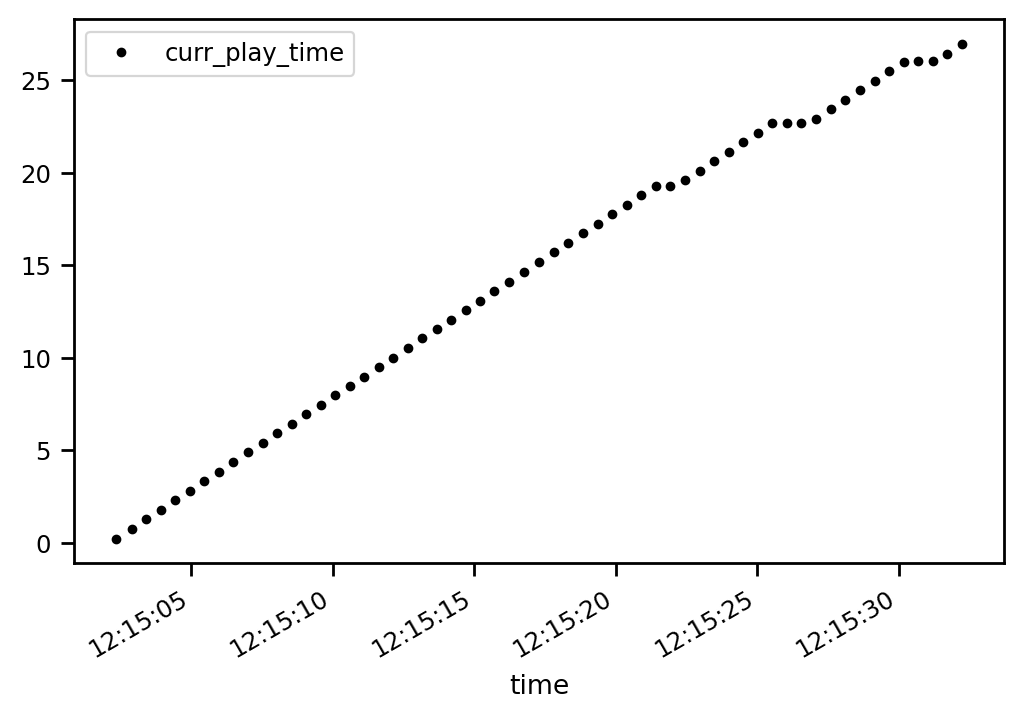

In [215]:
df_nerd_stats[['time', 'curr_play_time']].copy().set_index('time').plot(marker=".", markersize=5, drawstyle="default", lw=0)

<AxesSubplot:xlabel='time'>

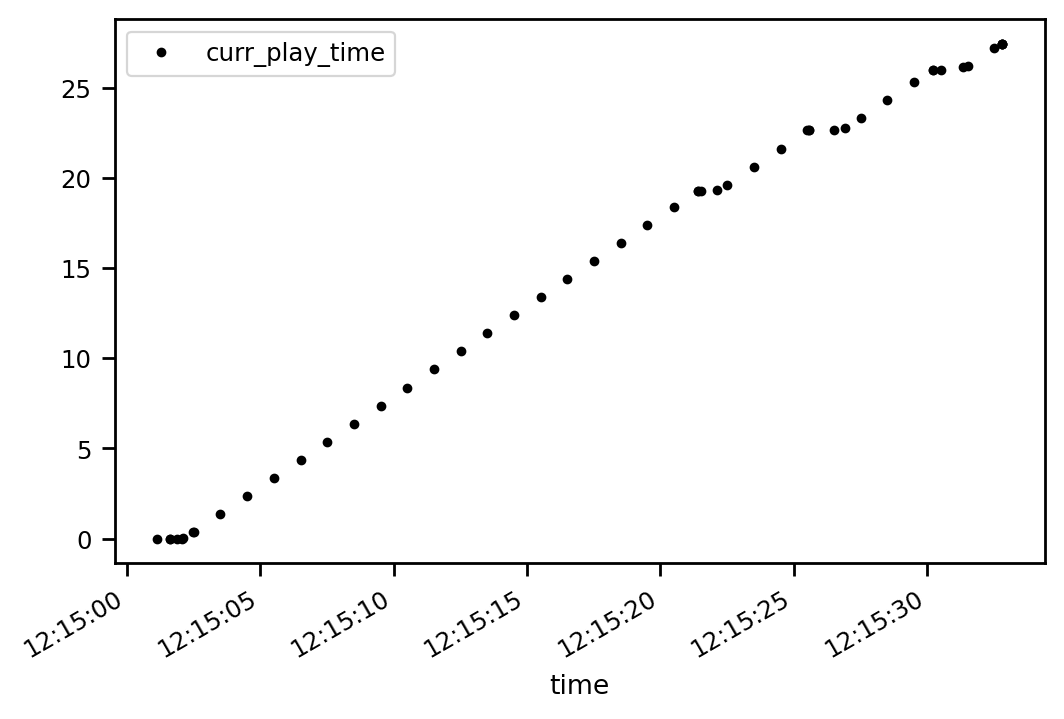

In [216]:
df_iframe[df_iframe.curr_play_time >= 0][['time', 'curr_play_time']].copy().set_index('time').plot(marker=".", markersize=5, drawstyle="default", lw=0)

<AxesSubplot:xlabel='time'>

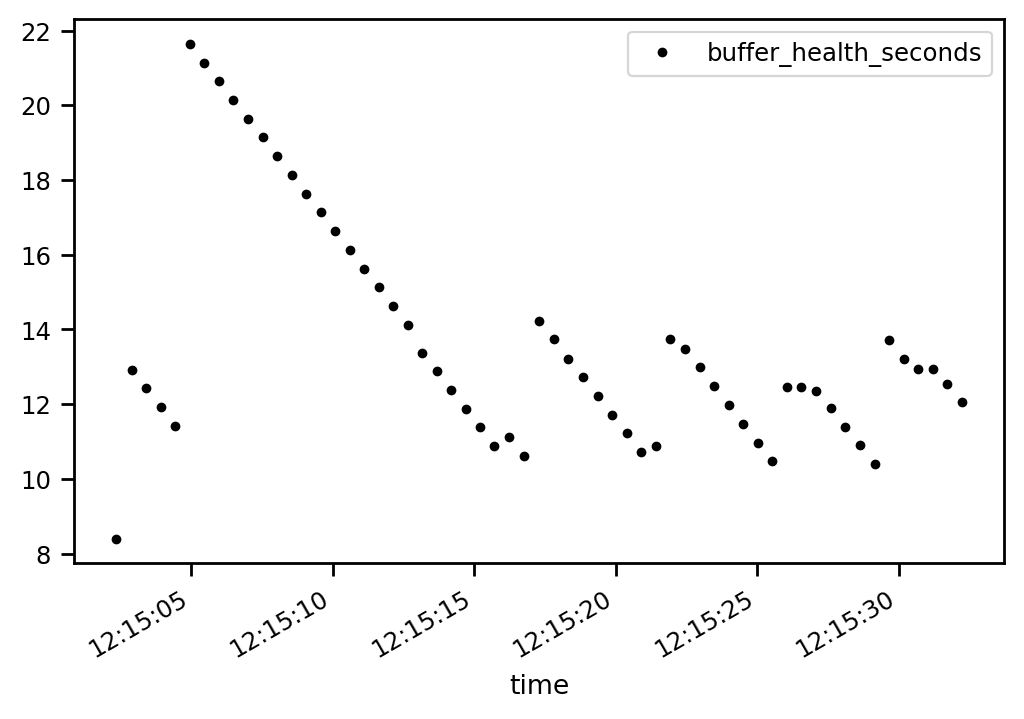

In [217]:
df_buffer_health = df_nerd_stats[['time', 'buffer_health_seconds']].copy().set_index('time')
df_buffer_health.plot(marker=".", markersize=5, drawstyle="default", lw=0)

<AxesSubplot:xlabel='time'>

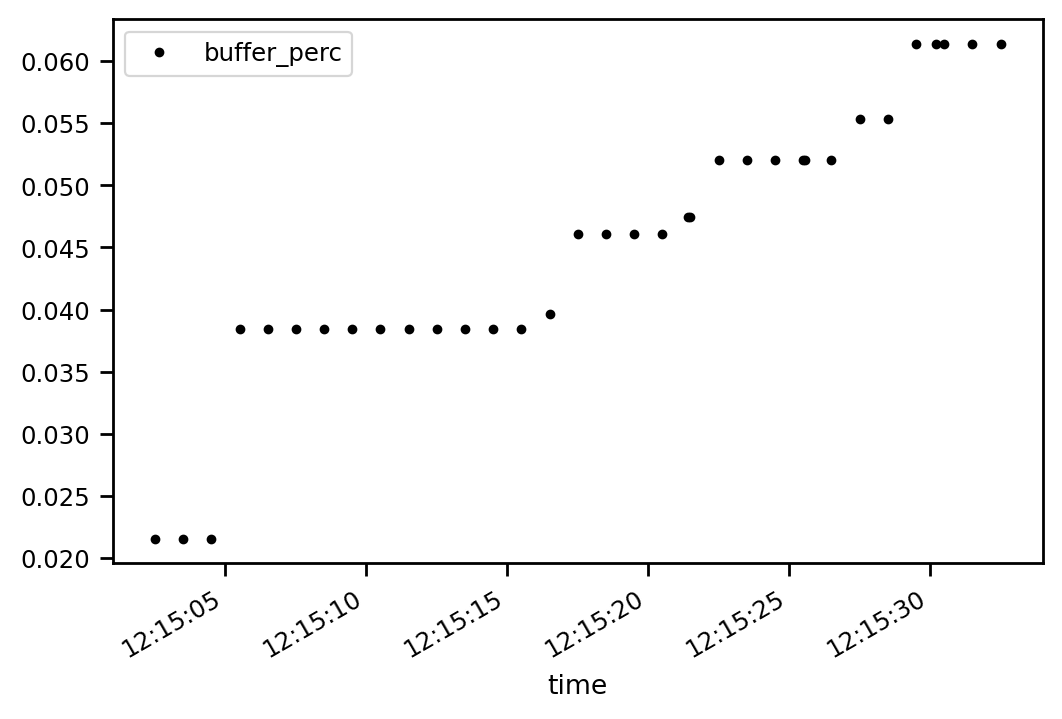

In [218]:
df_buffer_perc = df_iframe[(df_iframe.event_type == 'BufferLogging') & (df_iframe.buffer_perc > 0.)][['time', 'buffer_perc']].copy().set_index('time')
df_buffer_perc.plot(marker=".", markersize=5, drawstyle="default", lw=0)

In [256]:
df_iframe

,time,event_type,buffer_perc,curr_play_time,video_dur,current_quality,available_qualities,msm_id
65934,2022-03-01 12:14:59.873199872,PlayerReady,-1.000000,-1.000000,-1.0,-1,-1,0aa247d6-d3ee-0b0d-f1ed-7487e6213fe4
65935,2022-03-01 12:15:01.130100224,PlayerStateCUED,0.000000,0.000000,-1.0,unknown,[],0aa247d6-d3ee-0b0d-f1ed-7487e6213fe4
65936,2022-03-01 12:15:01.505100032,PlayStartedFromFunction,-1.000000,-1.000000,635.0,-1,-1,0aa247d6-d3ee-0b0d-f1ed-7487e6213fe4
65937,2022-03-01 12:15:01.602900224,PlayerStateBUFFERING,0.000000,0.000000,-1.0,unknown,-1,0aa247d6-d3ee-0b0d-f1ed-7487e6213fe4
65938,2022-03-01 12:15:01.603100160,BufferLogging,0.000000,0.000000,-1.0,unknown,-1,0aa247d6-d3ee-0b0d-f1ed-7487e6213fe4
65939,2022-03-01 12:15:01.897900032,QualityChangeMedium,0.000000,0.000000,-1.0,medium,-1,0aa247d6-d3ee-0b0d-f1ed-7487e6213fe4
65940,2022-03-01 12:15:02.078600192,QualityChange1440,0.000000,0.000000,-1.0,hd1440,-1,0aa247d6-d3ee-0b0d-f1ed-7487e6213fe4
65941,2022-03-01 12:15:02.097199872,PlayerStatePLAYING,0.013270,0.031704,-1.0,hd1440,"['hd2160', 'hd1440', 'hd1080', 'hd720', 'large...",0aa247d6-d3ee-0b0d-f1ed-7487e6213fe4
65942,2022-03-01 12:15:02.470600192,QualityChange2160,0.021558,0.339624,-1.0,hd2160,-1,0aa247d6-d3ee-0b0d-f1ed-7487e6213fe4
65943,2022-03-01 12:15:02.512699904,BufferLogging,0.021558,0.381624,-1.0,hd2160,-1,0aa247d6-d3ee-0b0d-f1ed-7487e6213fe4


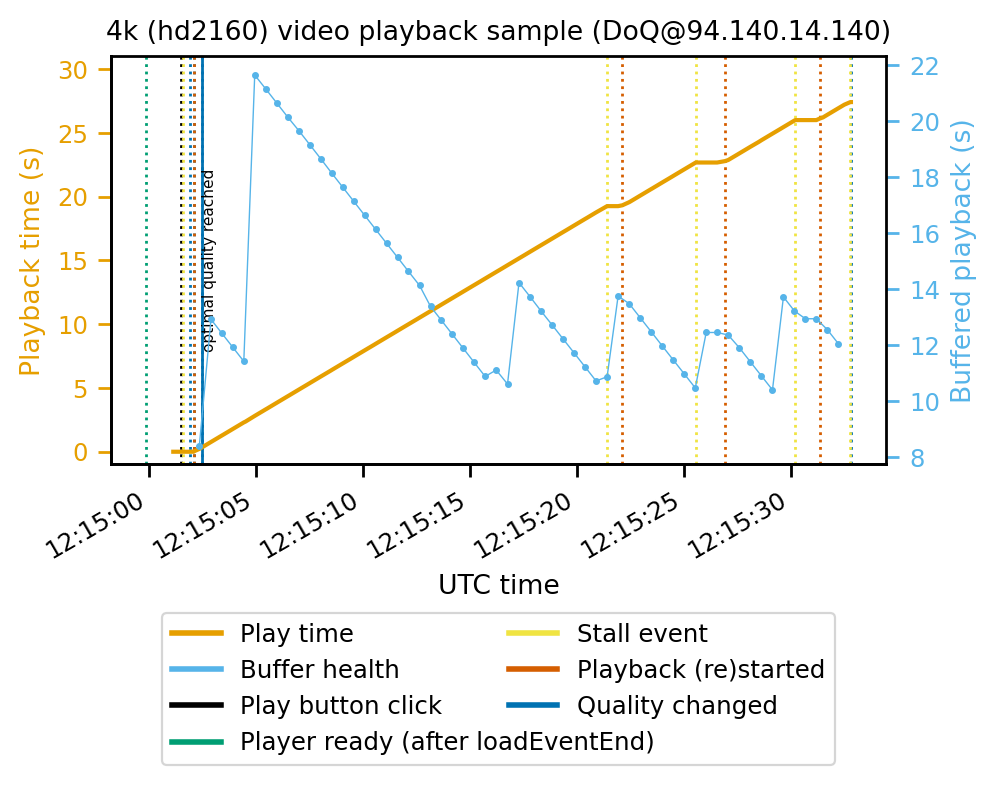

In [325]:
fig = plt.figure(figsize=(5,3))
ax = fig.add_subplot(111)
#dfplt.plot(y="query_name", ax=ax2, label="Fastly IPv6", marker=".", markersize=mrksize, drawstyle="default", color='C0', lw=0)
#df_iframe[df_iframe.curr_play_time >= 0][['time', 'curr_play_time']].copy().set_index('time').plot(ax=ax, marker=".", markersize=5, drawstyle="default", lw=0)
#df_nerd_stats[['time', 'curr_play_time']].copy().set_index('time').plot(ax=ax, marker=".", markersize=5, drawstyle="default", lw=0)
df_tmp = pd.concat([df_iframe[df_iframe.curr_play_time >= 0][['time', 'curr_play_time']].copy(), df_nerd_stats[['time', 'curr_play_time']].copy()]).set_index('time')
df_tmp.plot(ax=ax, marker=".", markersize=0, drawstyle="default", lw=1.5, color='C1')

color_map = {'Play time':'C1','Buffer health':'C2', 'Play button click':'black', 'Player ready (after loadEventEnd)':'C3', 'Stall event':'C4', 
            'Playback (re)started':'C6', 'Quality changed':'C5'}

#https://stackoverflow.com/a/48127302
#pandas uses 64bit ints to represent a date, plotting converts them to 32bit -> this may fail
buffer_events_list = [datetime.fromtimestamp(dt.timestamp()) for dt in df_iframe[df_iframe.event_type == 'PlayerStateBUFFERING'].time]
_ = ax.vlines(x=df_iframe[df_iframe.event_type == 'PlayerReady'].time.values[0], ymin=-1, ymax=31, colors='C3', lw=1, ls=':')
_ = ax.vlines(x=df_iframe[df_iframe.event_type == 'PlayStartedFromFunction'].time.values[0], ymin=-1, ymax=31, colors='black', lw=1, ls=':')
_ = ax.vlines(x=pd.to_datetime(df_iframe[df_iframe.event_type.str.startswith('QualityChange')].time), ymin=-1, ymax=31, colors='C5', lw=1, ls=':')
_ = ax.vlines(x=pd.to_datetime(df_iframe[df_iframe.event_type == 'PlayerStateBUFFERING'].time), ymin=-1, ymax=31, colors='C4', lw=1, ls=':')
_ = ax.vlines(x=pd.to_datetime(df_iframe[df_iframe.event_type == 'PlayerStatePLAYING'].time), ymin=-1, ymax=31, colors='C6', lw=1, ls=':')
_ = ax.vlines(x=list(pd.to_datetime(df_iframe[df_iframe.event_type == 'QualityChange2160'].sort_values('time').time))[0], ymin=-1, ymax=31, colors='C5', lw=1, )
ax.text(list(pd.to_datetime(df_iframe[df_iframe.event_type == 'QualityChange2160'].sort_values('time').time))[0], 15, "optimal quality reached", rotation=90, verticalalignment='center', color='C0', size='xx-small')



ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
#ax.spines['left'].set_position(('axes', -0.0))
ax.tick_params(axis='y', colors='C1')
ax.yaxis.label.set_color('C1')

ax.set_title("4k (hd2160) video playback sample (DoQ@94.140.14.140)")

ax.set_xlabel("UTC time")
ax.set_ylabel('Playback time (s)')
ax.set_ylim(-1,31)

ax2 = ax.twinx()
df_buffer_health.plot(ax=ax2, marker=".", markersize=3, drawstyle="default", lw=0.5, color='C2')
#ax2.spines['right'].set_color('C2')
ax2.yaxis.label.set_color('C2')
ax2.tick_params(axis='y', colors='C2')
ax2.set_ylabel('Buffered playback (s)')

ax.legend_.remove()
ax2.legend_.remove()

legend_elements = [mpl.lines.Line2D([0], [0], color=color_map[legend_item], lw=2, label=legend_item, marker='') for legend_item in color_map.keys()]
plt.gca().legend(handles=legend_elements, loc='center', ncol=2, bbox_to_anchor=(.5, -.55), columnspacing=-6)

plt.show()

fig.savefig('figures/video_timeline.pdf', format='pdf', bbox_inches='tight')